In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data.dataset import dataset_Krylov, dataset_FD
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec_trig_solve
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.utils import direc_graph_from_linear_system_sparse
from train import train

# Setup experiment

In [3]:
dataset = 'krylov'                # 'krylov', 'simple'
grid = 32
N_samples_train = 30
N_samples_test = 5

rhs_train = rhs_test = 'random'           # 'random', 'laplace', [5, 5, 2]
k_train = k_test = 'poisson'           # 'random', 'poisson', [5, 5, 2]
rhs_offset_train = rhs_offset_test = 0
k_offset_train = k_offset_test = 10
lhs_type = 'fd'                        # 'fd', 'ilu0', 'ilu1', 'ilu2'

cg_repeats = 100
if dataset == 'simple': cg_repeats = 1

In [4]:
layer_ = ConstantConv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
loss_type = 'notay'               # Either 'llt' or 'notay'
with_cond = True               # If True will calculate cond during training. Extremly bad scaling (materialization of matrix)
with_final_cond = False         # If True will calculate cond with final L. Also bad scaling

In [5]:
batch_size = 16
lr = 1e-4
epoch_num = 150

In [6]:
# # Uncomment and setup to make steps in learning rate

# steps_per_batch = N_samples_train * cg_repeats // batch_size
# start, stop, step = 45*steps_per_batch, 101*steps_per_batch, 45*steps_per_batch
# decay_size = 1e-1
# lr = optax.piecewise_constant_schedule(
#     lr,
# #     {k: v for k, v in zip([37], [1e-1])}
#     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

# Make dataset

In [7]:
s1 = perf_counter()
if dataset == 'krylov':
    A_train, A_pad_train, b_train, u_exact_train, bi_edges_train, res_train, u_app_train = dataset_Krylov(grid, N_samples_train, seed=42, rhs_distr=rhs_train, rhs_offset=rhs_offset_train,
                                                                                             k_distr=k_train, k_offset=k_offset_train, cg_repeats=cg_repeats, lhs_type=lhs_type)
    A_test, A_pad_test, b_test, u_exact_test, bi_edges_test, res_test, u_app_test = dataset_Krylov(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
                                                                                       k_distr=k_test, k_offset=k_offset_test, cg_repeats=cg_repeats, lhs_type=lhs_type)
elif dataset == 'simple':
    A_train, A_pad_train, b_train, u_exact_train, bi_edges_train = dataset_FD(grid, N_samples_train, seed=42, rhs_distr=rhs_train, rhs_offset=rhs_offset_train,
                                                                 k_distr=k_train, k_offset=k_offset_train, lhs_type=lhs_type)
    A_test, A_pad_test, b_test, u_exact_test, bi_edges_test = dataset_FD(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
                                                             k_distr=k_test, k_offset=k_offset_test, lhs_type=lhs_type)
print(perf_counter() - s1)

11.298154664982576


# Train model

In [8]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed), layer_=layer_)

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),    
    update_node_fn = FullyConnectedNet(features=[32, 16, 16], N_layers=2, key=random.PRNGKey(seed), layer_=layer_),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2753


In [9]:
# data = (X_train, X_test, y_train, y_test)
if dataset == 'krylov':
    data = (
        [A_train, A_pad_train, b_train, bi_edges_train, u_exact_train, res_train, u_app_train],
        [A_test, A_pad_test, b_test, bi_edges_test, u_exact_test, res_test, u_app_test],
        jnp.array([1]), jnp.array([1])
    )
elif dataset == 'simple':
    data = (
        [A_train, A_pad_train, b_train, bi_edges_train, u_exact_train],
        [A_test, A_pad_test, b_test, bi_edges_test, u_exact_test],
        jnp.array([1]), jnp.array([1])
    )
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size
}

### Pre-train with $LL^T$ loss 

In [10]:
# batch_size = 4
# lr = 1e-2

# # steps_per_batch = N_samples_train // batch_size
# # start, stop, step = 20*steps_per_batch, 101*steps_per_batch, 20*steps_per_batch
# # decay_size = 1e-1
# # lr = optax.piecewise_constant_schedule(
# #     lr,
# # #     {k: v for k, v in zip([37], [1e-1])}
# #     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# # )
# pretrain_train_config = {
#     'optimizer': optax.adam,
#     'lr': lr,
#     'optim_params': {},#{'weight_decay': 1e-8}, 
#     'epoch_num': 150,
#     'batch_size': batch_size
# }
# model, losses_pre = train(model, data, pretrain_train_config, loss_name='llt', with_cond=True)

-----

In [11]:
s = perf_counter()
model, losses = train(model, data, train_config, loss_name=loss_type, with_cond=with_cond, repeat_step=cg_repeats)
dt = perf_counter() - s

In [12]:
dt

2985.2737914709724

In [13]:
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(*direc_graph_from_linear_system_sparse(A_pad_test[::cg_repeats, ...], b_test[::cg_repeats, ...])[:-1], bi_edges_test[::cg_repeats, ...])
del model, data, A_train, A_pad_train, b_train, u_exact_train, bi_edges_train, bi_edges_test
if dataset == 'krylov': del res_train, res_test, u_app_train, u_app_test
clear_caches()

Final values
  train loss: 0.6335
   test loss: 0.6323
    LLT cond: 11

Minimim test loss `0.6322` at epoch `43`

Minimim test P^(-1)A cond `10` at epoch `38`


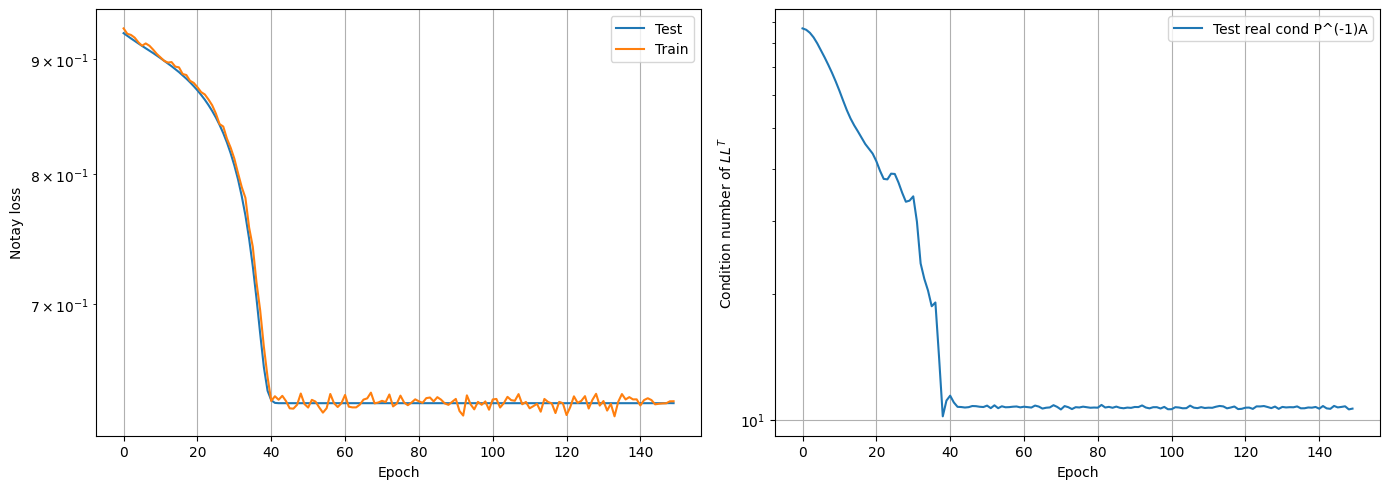

In [14]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))

# No pre-train
axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')

# # With pre-train
# axes[0].plot(range(len(losses_pre[0])), losses_pre[1], label='Test')
# axes[0].plot(range(len(losses_pre[0])), losses_pre[0], label='Train')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[1], label='Test')
# axes[0].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[0], label='Train')

axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Notay loss');
axes[0].grid();


if with_cond:
    # No pre-train
    axes[1].plot(range(len(losses[0])), losses[2], label='Test real cond P^(-1)A')

    # With pre-train
    # axes[1].plot(range(len(losses_pre[0])), losses_pre[2], label='Test')
    # axes[1].plot(range(len(losses_pre[0]), len(losses_pre[0])+len(losses[0])), losses[2], label='Test')

    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Condition number of $LL^T$')
    axes[1].grid();


# axes[0].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# axes[1].axvline(pretrain_train_config['epoch_num'], 0, 1e11, linestyle='--', c='k')
# for vl in [28]:#[13, 17, 22, 25, 29, 39, 59, 79]:
#     axes[0].axvline(vl, 0, 1e11, linestyle='--', c='k')
#     axes[1].axvline(vl, 0, 1e11, linestyle='--', c='k')
plt.tight_layout()


if with_cond: 
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
    print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')
else:
    print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}')
    print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
if with_final_cond:
    cond_A, cond_LLT = jit(asses_cond)(A_test[::cg_repeats, ...], L)
    print(f'\nTest lhs A cond: {cond_A:.0f}, test P^(-1)A cond: {cond_LLT:.0f}')

# Apply model to CG

In [15]:
# if dataset == 'krylov':
#     A_test, _, b_test, _, _, _, _ = dataset_Krylov(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
#                                                                                        k_distr=k_test, k_offset=k_offset_test, cg_repeats=1, lhs_type='fd')
# elif dataset == 'simple':
#     A_test, _, b_test, _, _ = dataset_FD(grid, N_samples_test, seed=43, rhs_distr=rhs_test, rhs_offset=rhs_offset_test,
#                                                              k_distr=k_test, k_offset=k_offset_test, lhs_type='fd')

In [16]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...], N_iter=300, prec_func=None, seed=42)

In [17]:
# Prec = LL^T
prec = partial(llt_prec_trig_solve, L=L)

s_prec = perf_counter()
X_LLT, R_LLT = ConjGrad(A_test[::cg_repeats, ...], b_test[::cg_repeats, ...], N_iter=300, prec_func=prec, seed=42)
print(perf_counter() - s_prec)

11.544634526013397


        Simple CG: {0.001: 74, 1e-06: 99, 1e-12: 161}
Preconditioned CG: {0.001: 15, 1e-06: 22, 1e-12: 38}


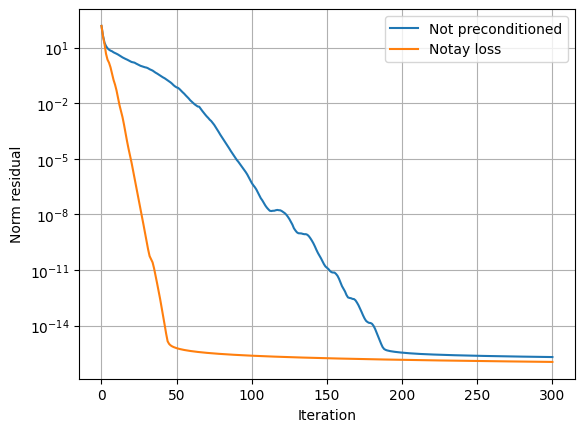

In [18]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="Notay loss")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

# plt.ylim([1e-15, 1e0]);
# plt.vlines([10, 20], [1e-15]*2, [100]*2, linestyle='--', color='k')

res_I_dict = iter_per_residual(R_I)
res_LLT_dict = iter_per_residual(R_LLT)
print('        Simple CG:', res_I_dict)
print('Preconditioned CG:', res_LLT_dict)

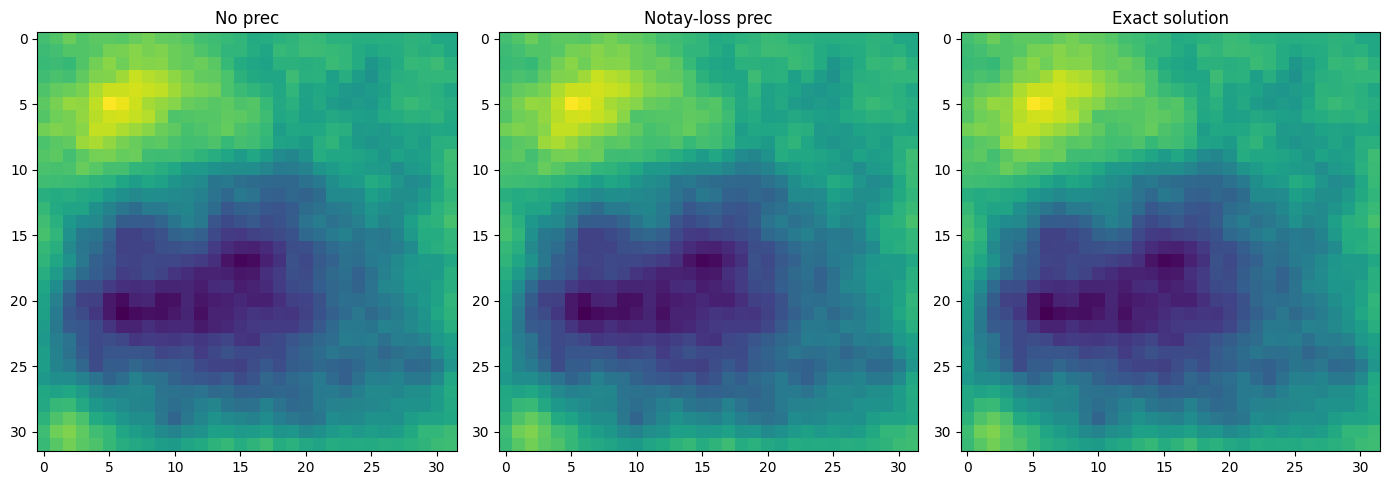

In [19]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()